In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Check how many times polygons are repeated

In [3]:
import geopandas as gpd

# Load the shapefile
shapefile_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/cleaned_soil.shp"
gdf = gpd.read_file(shapefile_path)

# Number of polygons
num_polygons = len(gdf)
print("Number of polygons:", num_polygons)


Number of polygons: 5254


In [4]:
num_unique_polygons = gdf['geometry'].drop_duplicates().shape[0]
print("Number of unique polygons:", num_unique_polygons)


Number of unique polygons: 3104


In [5]:
import geopandas as gpd

# Load shapefile
shapefile_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/cleaned_soil.shp"
gdf = gpd.read_file(shapefile_path)

# Convert geometries to WKT for comparison
geom_wkt = gdf['geometry'].apply(lambda x: x.wkt)

# Count occurrences of each unique polygon
geom_counts = geom_wkt.value_counts()

# Maximum number of times a polygon is repeated
max_repeats = geom_counts.max()
print("The maximum number of repetitions for a polygon is:", max_repeats)

# Optionally, see which polygon(s) is repeated the most
most_repeated = geom_counts[geom_counts == max_repeats]
print("Most repeated polygon(s):")
print(most_repeated)


The maximum number of repetitions for a polygon is: 7
Most repeated polygon(s):
geometry
POLYGON ((8.616666666666934 36.86666666666665, 8.625000000000266 36.86666666666665, 8.625000000000266 36.85833333333332, 8.650000000000265 36.85833333333332, 8.650000000000265 36.84999999999998, 8.66666666666693 36.84999999999998, 8.66666666666693 36.84166666666665, 8.675000000000264 36.84166666666665, 8.675000000000264 36.82499999999998, 8.66666666666693 36.82499999999998, 8.66666666666693 36.81666666666665, 8.641666666666932 36.81666666666665, 8.641666666666932 36.808333333333316, 8.625000000000266 36.808333333333316, 8.625000000000266 36.79999999999998, 8.591666666666931 36.79999999999998, 8.591666666666931 36.79166666666665, 8.583333333333599 36.79166666666665, 8.583333333333599 36.78333333333332, 8.550000000000267 36.78333333333332, 8.550000000000267 36.79166666666665, 8.54166666666693 36.79166666666665, 8.54166666666693 36.81666666666665, 8.5583333333336 36.81666666666665, 8.5583333333336 36.

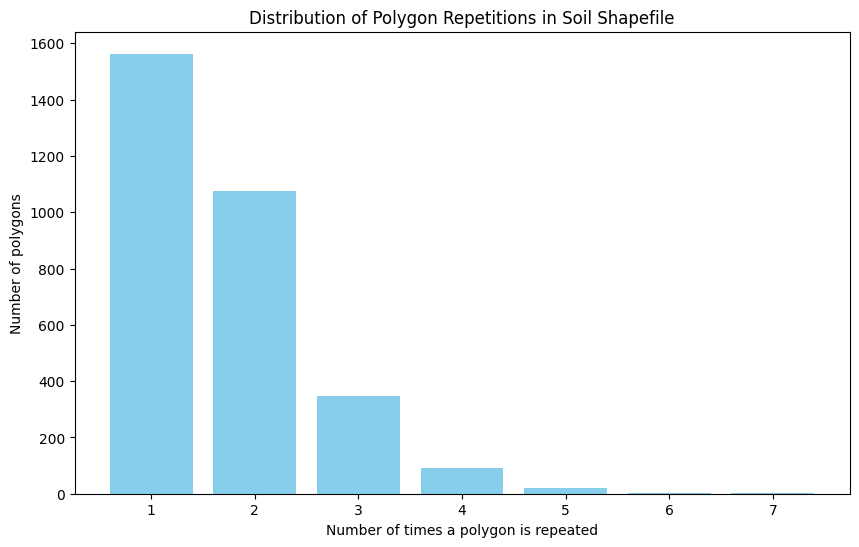

In [6]:
import matplotlib.pyplot as plt

# Count how many polygons are repeated each number of times
repeat_counts = geom_counts.value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(10,6))
plt.bar(repeat_counts.index, repeat_counts.values, color='skyblue')
plt.xlabel("Number of times a polygon is repeated")
plt.ylabel("Number of polygons")
plt.title("Distribution of Polygon Repetitions in Soil Shapefile")
plt.xticks(repeat_counts.index)  # show all repetition counts on x-axis
plt.show()


# Soil

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 78.2 MB/s eta 0:00:00


In [ ]:
!apt-get install -y mdbtools


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libmdb3 libmdbsql3
Suggested packages:
  bash-completion
The following NEW packages will be installed:
  libmdb3 libmdbsql3 mdbtools
0 upgraded, 3 newly installed, 0 to remove and 41 not upgraded.
Need to get 136 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmdb3 amd64 1.0.0+dfsg-1 [68.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmdbsql3 amd64 1.0.0+dfsg-1 [18.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mdbtools amd64 1.0.0+dfsg-1 [48.3 kB]
Fetched 136 kB in 1s (193 kB/s)
Selecting previously unselected package libmdb3:amd64.
(Reading database ... 121703 files and directories currently installed.)
Preparing to unpack .../libmdb3_1.0.0+dfsg-1_amd64.deb ...
Unpacking libmdb3:amd64 (1.0.0+dfsg-1

In [ ]:
import subprocess         # to run mdb-export from mdbtools
import pandas as pd       # for DataFrame operations
from io import StringIO   # to read CSV data from the command output


## keep dominant soil only

 Load SMU table

In [ ]:
mdb_path = "/content/drive/MyDrive/data_set/soil_type/HWSD2_DB/HWSD2.mdb"
table_smu = "HWSD2_SMU"

# Export the SMU table to CSV using mdbtools
output_smu = subprocess.check_output(["mdb-export", mdb_path, table_smu])
df_smu  = pd.read_csv(StringIO(output_smu.decode("utf-8")))

keep dominant soil

In [ ]:
import pandas as pd
df1 = pd.read_csv("/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/filtered_df_cleaned.csv")

# --- Assume df1 and df_smu are already loaded ---

# Step 1: Find max SHARE per ID
max_share_idx = df1.groupby('ID')['SHARE'].idxmax()
df_max_share = df1.loc[max_share_idx].copy()  # preliminary df with highest SHARE per ID

# Step 2: Handle ties where multiple rows have same SHARE
# Find IDs that have ties
ids_with_ties = df1[df1.duplicated(subset=['ID','SHARE'], keep=False)]['ID'].unique()

rows_to_keep = []

for _id in ids_with_ties:
    # All rows for this ID
    rows = df1[df1['ID'] == _id]
    # Max SHARE
    max_share = rows['SHARE'].max()
    tied_rows = rows[rows['SHARE'] == max_share]

    if len(tied_rows) == 1:
        rows_to_keep.append(tied_rows.iloc[0])
    else:
        # Multiple tied rows, compare FAO90 with df_smu
        smu_fao_values = df_smu[df_smu['HWSD2_SMU_ID'] == _id]['FAO90'].unique()
        # Keep the first row where FAO90 matches SMU
        match_row = tied_rows[tied_rows['FAO90'].isin(smu_fao_values)]
        if not match_row.empty:
            rows_to_keep.append(match_row.iloc[0])
        else:
            # If none match, keep first tied row anyway
            rows_to_keep.append(tied_rows.iloc[0])

# Step 3: Combine kept rows for all IDs
# Include IDs without ties (already in df_max_share but remove those handled in ties)
ids_no_ties = set(df_max_share['ID']) - set(ids_with_ties)
df_no_ties = df_max_share[df_max_share['ID'].isin(ids_no_ties)]

# Final filtered DataFrame
df_filtered_final = pd.concat([df_no_ties, pd.DataFrame(rows_to_keep)], ignore_index=True)

print(f"Total rows after filtering: {len(df_filtered_final)}")
print(f"Unique IDs: {df_filtered_final['ID'].nunique()}")


Total rows after filtering: 389
Unique IDs: 389


In [ ]:
# --- Save filtered df_layer to CSV ---
output_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/final/filtered_df_cleaned.csv"
df_filtered_final.to_csv(output_path, index=False)

print(f"Filtered df_layer saved to: {output_path}")


Filtered df_layer saved to: /content/drive/MyDrive/data_set/soil_type/shapefiles/clean/final/filtered_df_cleaned.csv


In [ ]:
!pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 101.4 MB/s eta 0:00:00


In [ ]:
import rasterio
from rasterio.features import shapes
import fiona
from fiona.crs import from_epsg
import numpy as np
from shapely.geometry import shape, mapping
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:


raster_path = "/content/drive/MyDrive/data_set/soil_type/HWSD_Algeria_Tunisia.tif"
shapefile_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/final/cleaned_soil.shp"

with rasterio.open(raster_path) as src:
    raster_data = src.read(1)
    transform = src.transform
    crs = src.crs

    # Mask to ignore no-data values
    mask = raster_data != src.nodata

    # Generate shapes for all contiguous regions (do NOT merge by value)
    shapes_gen = shapes(raster_data, mask=mask, transform=transform)

    # Define schema for shapefile
    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'}
    }

    # Write shapefile
    with fiona.open(shapefile_path, 'w', driver='ESRI Shapefile', crs=crs, schema=schema) as shp:
        for geom, value in shapes_gen:
            shp.write({
                'geometry': geom,
                'properties': {'id': int(value)}
            })


In [ ]:
import fiona
from collections import Counter

shapefile_path =  "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/final/cleaned_soil.shp"

# Read shapefile and extract polygon IDs
with fiona.open(shapefile_path, 'r') as shp:
    polygon_ids = [int(feature['properties']['id']) for feature in shp]

# Total number of polygons
total_polygons = len(polygon_ids)
print("Total number of polygons:", total_polygons)

id_counts = Counter(polygon_ids)
# Total unique IDs
print("\nTotal unique raster IDs:", len(id_counts))

Total number of polygons: 3104

Total unique raster IDs: 389


In [ ]:
import rasterio
from rasterio.features import shapes
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape

# --- Paths ---
raster_path = "/content/drive/MyDrive/data_set/soil_type/HWSD_Algeria_Tunisia.tif"
csv_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/final/filtered_df_cleaned.csv"
output_path = "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/final/cleaned_soil.shp"

# --- Load raster ---
with rasterio.open(raster_path) as src:
    raster = src.read(1)  # read first band
    transform = src.transform
    crs = src.crs

# --- Create polygons for each raster cell with a value ---
mask = raster != src.nodata  # only valid data
shapes_gen = shapes(raster, mask=mask, transform=transform)

# --- Convert to GeoDataFrame ---
polygons = []
values = []
for geom, value in shapes_gen:
    polygons.append(shape(geom))
    values.append(value)

raster_gdf = gpd.GeoDataFrame({'ID': values, 'geometry': polygons}, crs=crs)

# --- Load CSV with additional attributes ---
df_csv = pd.read_csv(csv_path)

if 'geometry' in df_csv.columns:
    df_csv_no_geom = df_csv.drop(columns=['geometry'])
else:
    df_csv_no_geom = df_csv

# --- Join CSV attributes to raster polygons using 'ID' ---
merged_gdf = raster_gdf.merge(df_csv_no_geom, on='ID', how='left')

# --- Save to shapefile ---
merged_gdf.to_file(output_path)

print(f"Shapefile saved at: {output_path}")
print(f"Number of polygons: {len(merged_gdf)}")


Shapefile saved at: /content/drive/MyDrive/data_set/soil_type/shapefiles/clean/final/cleaned_soil.shp
Number of polygons: 3104


In [ ]:
print("Attributes (columns):")
print(merged_gdf.columns.tolist())


Attributes (columns):
['ID', 'geometry', 'DB_ID', 'FAO90', 'WRB4', 'SHARE', 'COARSE', 'SAND', 'SILT', 'CLAY', 'USDA', 'SOTER', 'BULK', 'REF_BULK', 'ORG_CARBON', 'PH_WATER', 'TOTAL_N', 'CN_RATIO', 'CEC_SOIL', 'CEC_CLAY', 'CEC_EFF', 'TEB', 'BSAT', 'ALUM_SAT', 'ESP', 'TCARBON_EQ', 'GYPSUM', 'ELEC_COND']


        ID   DB_ID FAO90  WRB4  SHARE  COARSE  SAND  SILT  CLAY USDA  ...  \
0  31805.0   77553   CMx  CMcr     60       5    33    31    36  5.0  ...   
1  31805.0   77553   CMx  CMcr     60       5    33    31    36  5.0  ...   
2  31802.0   12266   ALh  ALha     70      11    40    41    19  9.0  ...   
3  31828.0   43672   CLp  CLpt     70      18    40    36    24  9.0  ...   
4   7001.0  291461    UR    TC    100      -9    -9    -9    -9    -  ...   

  CEC_CLAY  CEC_EFF  TEB  BSAT  ALUM_SAT  ESP  TCARBON_EQ  GYPSUM  ELEC_COND  \
0       34       15   17    82         0    1    0.000000     1.6          1   
1       34       15   17    82         0    1    0.000000     1.6          1   
2       26        6    5    47        21    1    0.000000     0.1          0   
3       61       32   32   100         0    5   27.299999     0.3          0   
4       -9       -9   -9    -9        -9   -9   -9.000000    -9.0         -9   

                                            geometry  
0

<Figure size 1200x1200 with 0 Axes>

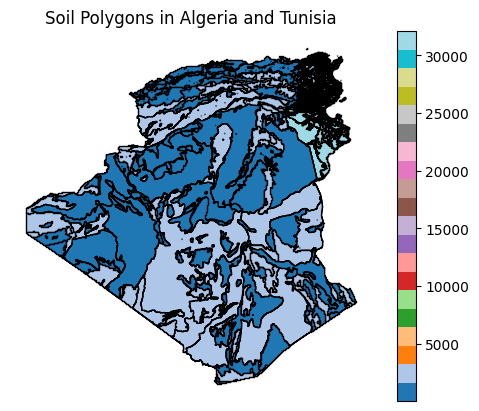

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

shapefile_path =  "/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/final/cleaned_soil.shp"


# Load shapefile with GeoPandas
gdf = gpd.read_file(shapefile_path)

# Quick look at the data
print(gdf.head())

# Plot the polygons colored by their ID
plt.figure(figsize=(12, 12))
gdf.plot(column='ID', cmap='tab20', legend=True, edgecolor='black')
plt.title("Soil Polygons in Algeria and Tunisia")
plt.axis('off')
plt.show()
